# **TUTORIAL**
## *First steps toward MSM*
**Author: Luca Sagresti**

\* mail me: luca.sagresti[at]sns.it

This tutorial is inspired by a published work by L. Sagresti et al. **JCTC**, 2022

#### Useful libraries for the tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt; import matplotlib as mpl
import glob
from scipy.linalg import solve
from scipy.interpolate import CubicSpline

#### Useful parameters for nice matplotlib plot

In [2]:
mpl.rcParams['figure.dpi']=200
mpl.rcParams['figure.titlesize']=8
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['lines.linewidth']=1.0
mpl.rcParams['axes.linewidth']=2.0
mpl.rcParams['xtick.major.pad']=8
mpl.rcParams['ytick.major.pad']=8
mpl.rcParams['ytick.minor.pad']=6
mpl.rcParams['xtick.labelsize']=6
mpl.rcParams['ytick.labelsize']=6
mpl.rcParams['axes.titlesize']=10
mpl.rcParams['axes.labelsize']=8
mpl.rc('text',usetex=False)
mpl.rcParams['axes.grid']='False'
mpl.rcParams['axes.axisbelow']='line'
mpl.rcParams['legend.loc']='best'
mpl.rcParams['legend.fontsize']=10

# Markov State Models

## Start with a 1-D potential

In [3]:
def double_well_potential(x):
    # Define an asymmetric double well pot with large barrier
    k = 3 # steepness of the barrier
    a0 = 1/128
    a2 = 1/4
    sigma = 1.0
    fac = sigma*np.sqrt(a0/(2*a2))
    return k*(a0*x**4-a2*x**2+sigma*fac*x)

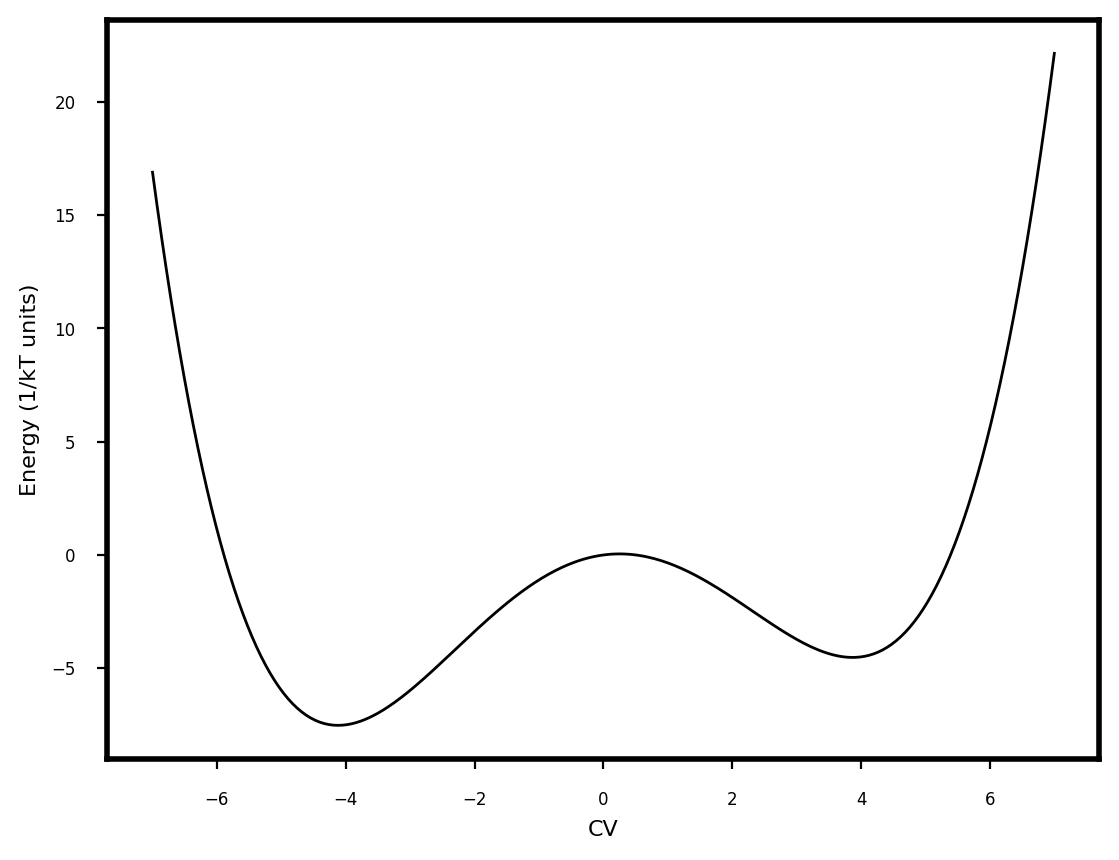

In [4]:
x = np.linspace(-7.0, 7.0, 400)
# Plot the trajectory with respect to the potential bins
plt.plot(x, double_well_potential(x), 'k')
plt.xlabel('CV')
plt.ylabel('Energy (1/kT units)')
#plt.legend()
plt.show()

## Play with the LD

In [5]:
def discretize_potential(potential_function, x_bins):
    potentials = potential_function(x_bins)
    forces = -np.gradient(potentials, x_bins)
    return potentials, forces

def langevin_dynamics(x0, potentials, forces, timesteps, dt, friction, temperature):
    positions = np.zeros((timesteps,))
    bin_indices = np.zeros((timesteps,), dtype=int)
    times = np.arange(0, timesteps * dt, dt)

    # Initial conditions
    positions[0] = x0
    bin_indices[0] = np.searchsorted(x_bins, x0)

    for i in range(1, timesteps):
        bin_index = bin_indices[i - 1]

        # Integrate Langevin equation
        dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))

        ld_B = dW * np.sqrt(2 * (temperature / friction))

        try:
            force = forces[bin_index]
        except IndexError:
            force = forces[num_bins]
            print('Used right wall')

        position = positions[i - 1] + (force / friction) * dt + ld_B

        # Uncomment for sanity check
        # print(position)

        # Check if the particle has crossed into a new bin
        bin_index = np.searchsorted(x_bins, position)
        positions[i] = position
        bin_indices[i] = bin_index

    return times, positions, bin_indices

Langevin Equation of a particle of mass M=1

$ẍ=-\nabla U(x)-\gamma ẋ+\sqrt((2\gamma k_BT))R(t)$

In the overdamped limit $ẍ$ is the smallest of all so one can write

$ẋ=-\frac{\nabla U(x)}{\gamma}+\sqrt(2(\frac{k_BT}{\gamma}))R(t)$

where the positions can be integrated iteratively.
This derivation assumes $\gamma$ not depending on the position of the particle (homogeneous media) otherwise one should integrate a general Smoluchowki equation.

In [6]:
# @title Langevin Dynamics parameter
x0 = 5 # @param {type:"slider", min:-5.0, max:5.0, step:0.1}
timesteps = 5000 # @param {type:"slider", min:100, max:10000, step:100}
dt = 0.001 # @param {type:"number"}
friction = 0.1 # @param {type:"slider", min:0.01, max:1, step:0.01}

temperature = 1.0 # @param {type:"slider", min:0.1, max:5, step:0.1}

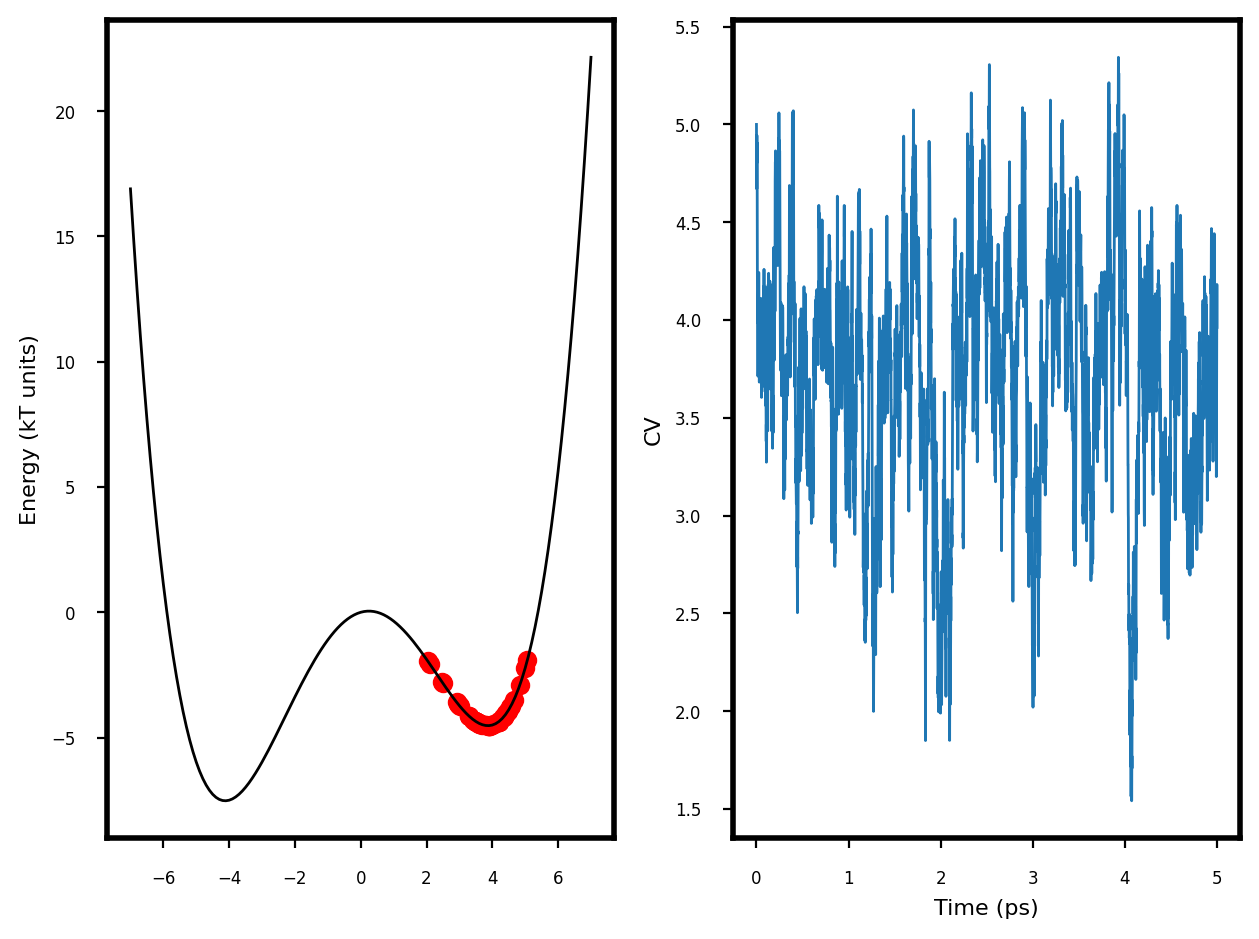

In [7]:
# Potential range
potential_min = -7.0
potential_max = 7.0
num_bins = 140

# Discretize the potential into bins
x_bins = np.linspace(potential_min, potential_max, num_bins + 1)
potentials, forces = discretize_potential(double_well_potential, x_bins)

# Perform Langevin dynamics
times, positions, bin_indices = langevin_dynamics(x0, potentials, forces,
                                                  timesteps, dt, friction, temperature)


fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot the potential bins
ax1.plot(x_bins, double_well_potential(x_bins), 'k', label='Potential')
ax1.scatter(positions[::100], double_well_potential(positions[::100]), c='red', marker='o', zorder=0.5)
ax1.set_ylabel('Energy (kT units)')


# Plot exploration of CV during time
ax2.plot(times, positions)
ax2.set_xlabel('Time (ps)')
ax2.set_ylabel('CV')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Measuring kinetics from short LD

In [10]:
# @title New Langevin Dynamics parameter

timesteps = 1000 # @param {type:"slider", min:100, max:10000, step:100}


dt = 0.001 # @param {type:"number"}


friction = 0.1 # @param {type:"slider", min:0.01, max:1, step:0.01}


temperature = 1.0 # @param {type:"slider", min:0.1, max:5, step:0.1}



In [11]:
# @title MSM parameters
start_basin = -4.0 # @param {type:"number"}

end_basin = 4.0 # @param {type:"number"}

discretization = 80 # @param {type:"slider", min:10, max:800, step:10}

replicas = 40 # @param {type:"slider", min:10, max:100, step:10}

lagtime = 10  # @param {type:"slider", min:0, max:500, step:10}

In [12]:
dx = np.linspace(start_basin, end_basin, discretization + 1)

# Perform N short Langevin dynamics

count_matrix = np.zeros((num_bins+1,num_bins+1))

for i in range(discretization):
    x0 = x_bins[i]
    for j in range(replicas):
        times, positions, bin_indices = langevin_dynamics(x0, potentials, forces,
                                                          timesteps, dt, friction, temperature)
        for n in range(int(timesteps/lagtime)-lagtime):
            ti = np.searchsorted(x_bins, positions[n])
            tj = np.searchsorted(x_bins, positions[n+lagtime])
            count_matrix[ti][tj]+=1

norm = count_matrix.sum(axis=1)
tmatrix=np.zeros((num_bins+1, num_bins+1))

for i in range(num_bins):
    if norm[i] != 0:
        tmatrix[i, :] = count_matrix[i, :] / norm[i]
    else:
        continue

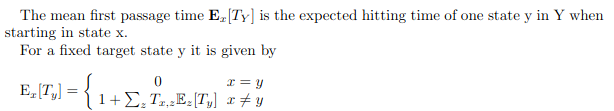

In [13]:
def MFPT(T, source, target):
    dim = T.shape[0]
    A = np.eye(dim) - tmatrix
    A[target, :] = 0.0
    A[target, target] = 1.0
    b = np.ones(dim)
    b[target] = 0.0
    m_t = solve(A, b)
    return m_t[source]

In [14]:
## Input Parameters to measure MFPT

start = np.searchsorted(x_bins, start_basin)
end = np.searchsorted(x_bins, end_basin)

mfpt = MFPT(tmatrix, start, end)

print(f'Mean First passage Time between A={start_basin} and B={end_basin} is {mfpt*lagtime*dt:.2f} ps ')

Mean First passage Time between A=-4.0 and B=4.0 is 654.26 ps 


### Fokker-Planck

In [15]:
""" %%% Function definition: Propagate
"""

def Coefficients(r, f, g, a, nbins, bc_ini, bc_end):

    # Second index indicates the column position on the tridiagonal matrix,
    # where 0 is left off-diagonal, 1 is on the diagonal and 2 is right off-diagonal elements on the same row.
    # The second index of r at the boundary matrix elements depends on the boundary conditions.

    r[0,0] = 0.0
    if( bc_ini == 1 ):  # //  absorbing
        r[0,1]=0.0
        r[0,2]=0.0

    if( bc_ini == 2 ):  # //  reflecting
        r[0,1]=a*0.5*g[0]*(f[0]+f[1])
        r[0,2]=a*0.5*g[1]*(f[0]+f[1])

    for i in range(1,nbins-1):
        j=i+1
        k=i-1
        r[i,0]=a*0.5*g[k]*(f[i]+f[k])
        r[i,1]=a*0.5*g[i]*(f[k]+2.0*f[i]+f[j])
        r[i,2]=a*0.5*g[j]*(f[i]+f[j])

    if( bc_end == 1 ):  # //  absorbing
        r[nbins-1,0]=0.0
        r[nbins-1,1]=0.0

    if( bc_end == 2 ):  # //  reflecting
        r[nbins-1,0]=a*0.5*g[nbins-2]*(f[nbins-1]+f[nbins-2]);
        r[nbins-1,1]=a*0.5*g[nbins-1]*(f[nbins-1]+f[nbins-2]);

    r[nbins-1,2]=0.0;

    ok = 1

    return ok


def Matrix(A_mat, r, nbins):
    #// A is the linear system matrix computed only once at the beginning
    #// and stored. A does not depend on p[i].

    for i in range(nbins):
        A_mat[i,0]= -1.0 * r[i,0]
        A_mat[i,1]=  1.0 + r[i,1]
        A_mat[i,2]= -1.0 * r[i,2]

    ok = 1

    return ok


def Vector(r, p, b, nbins):
    #// b is the non-homogeneous vector of the linear system,
    #// updated at each step with r (which depends on boundary conditions)
    #// and p[i] computed at previous step

    b[0]=(1.0-r[0,1])*p[0]+r[0,2]*p[1]

    for i in range(1,nbins-1):
        b[i]=(1.0-r[i,1])*p[i]+r[i,2]*p[i+1]+r[i,0]*p[i-1]

    b[nbins-1]=(1.0-r[nbins-1,1])*p[nbins-1]+r[nbins-1,0]*p[nbins-2]

    ok = 1
    return ok


def Tridiagonal(A, b, x, N):
    #double C, *temp;
    #int i;

    #// Solution of tridiagonal linear system
    temp=np.zeros(N)
    C=A[0,1]
    x[0]=b[0]/C

    for i in range (1,nbins):
        temp[i]=A[i-1,2]/C
        C=A[i,1]-A[i,0]*temp[i]
        x[i]=(b[i]-A[i,0]*x[i-1])/C

    for i in range(nbins-2,-1,-1):
        x[i] = x[i] - temp[i+1]*x[i+1]

    ok = 1

    return ok




The R bin is the 31 and the computed is 31
#
# dt = 1.000000e-03
# dx = 2.571429e-01
# a  = 7.561728e-03
#
# Total probability (sum of p[i]):     1.000000
#
# Max r coefficient (< 0.25):     0.170117
125.01176694319655 135.51844454716738
14281.85672917763 488.6982632692638
Step  1000  rate,gr   0.001951895    0.009656480
Step  4500  rate,gr   0.001954411    0.009735830
P(x) 200.0  Mean -3.851  Variance 0.301
0.674907419874029 1.05195250612051 4537.565904512045
P(x) 400.0  Mean -3.851  Variance 0.301
0.45511375295759765 1.763090765988724 7596.990501571517
P(x) 600.0  Mean -3.851  Variance 0.301
0.3068991716965016 2.2426362455461453 9660.067850044567
P(x) 800.0  Mean -3.851  Variance 0.301
0.20695287930963074 2.5660105876980963 11051.273291052556
P(x) 1000.0  Mean -3.851  Variance 0.301
0.13955558764723136 2.784073252492094 11989.411931623978
P(x) 1200.0  Mean -3.851  Variance 0.301
0.09410722918439093 2.931120558288282 12622.031732403007
P(x) 1400.0  Mean -3.851  Variance 0.301
0.063459

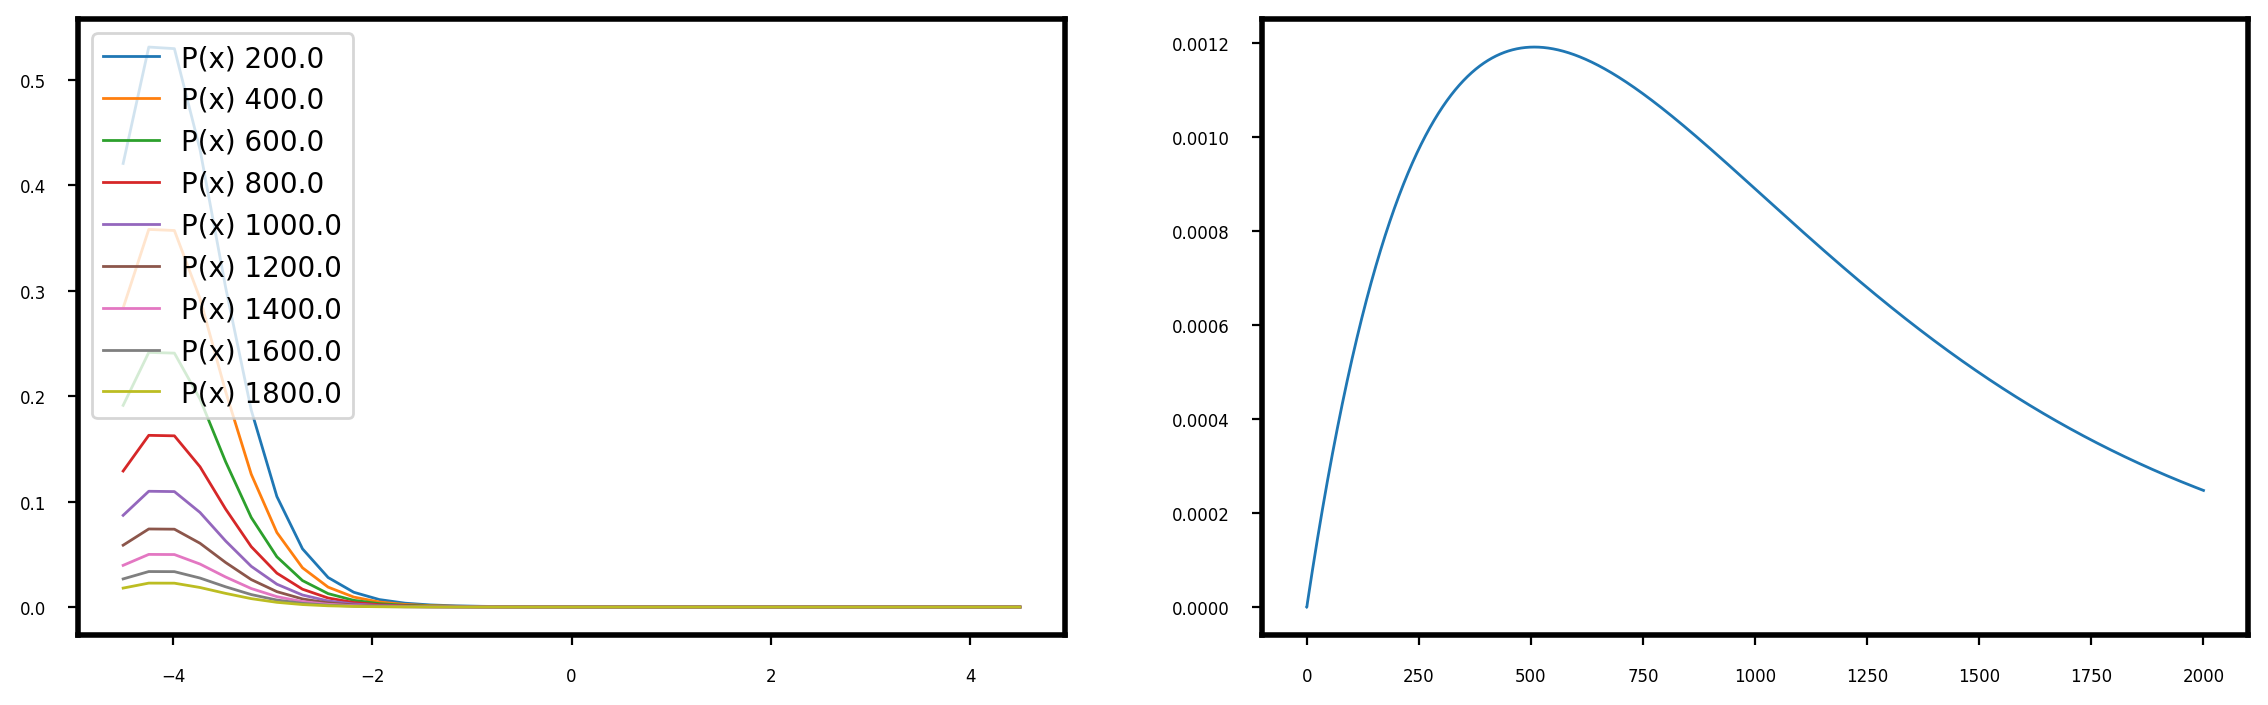

In [45]:
""" %%% Initialize some variables
"""

num_bins=35
x_bins = np.linspace(potential_min, potential_max, num_bins+1)
x_bins = np.linspace(-4.5, 4.5, num_bins+1)
free_energy_cs=CubicSpline(x,double_well_potential(x))

nbins = num_bins + 1
#beta   = 1./(0.0083144621 * 300)
beta   = 1.0
xp_ini = -4.0
t_ini  = 0.0
t_end  = 2000.0
dt     = 0.001    # ps
nsteps = int((t_end - t_ini) / dt)
bc_ini = 2
bc_end = 1
time_intervals = [t*t_end/10 for t in range(10)]
step_intervals = [int(x / dt) for x in time_intervals]

dx     = x_bins[1] - x_bins[0]

Dval = 10

D = np.ones(len(x_bins)) * Dval
diffusion_cs = CubicSpline(x_bins, D)

def gaussian(x, tt, Dval, Uval):
    sigma = np.sqrt(Dval)
    x0 = -Uval * Dval
    y = (1.0/np.sqrt(4.0*np.pi*Dval*tt)) * np.exp((-(x-x0*tt)**2 ) / (4.0*Dval*tt))
    return y


#===========================

r_coef = np.zeros((nbins,3))
A_mat = np.zeros((nbins,3))
b_vec = np.zeros(nbins)


# Initialize function
g_func = np.exp(beta * free_energy_cs(x_bins))
f_func = diffusion_cs(x_bins) * np.exp(-1.0 * beta * free_energy_cs(x_bins))

p_func = np.zeros(nbins)
idx = int((xp_ini - start_basin) / dx)
p_func[idx] = 1.0

p_func_R = np.zeros(nsteps)
p_tot_func_R = np.zeros(nsteps)
p_func_R_bin = int((end_basin - (start_basin - dx/2.0)) / dx)
print('The R bin is the %d and the computed is %d'%(p_func_R_bin,int((end_basin - (start_basin - dx/2.0)) / dx)))
p_func_L = np.zeros(nsteps)
p_tot_func_L = np.zeros(nsteps)

#    /* FAI ATTENZIONE ALLA DEFINIZIONE DI dx */
#dx = (1.0/float(nbins - 1))
a  = 0.5 * dt / (dx*dx)

p_sum = np.sum(p_func)

print("#\n# dt = %e\n# dx = %e\n# a  = %e\n#" % (dt, dx, a))
print("# Total probability (sum of p[i]): %12.6lf\n#" % (np.sum(p_func)))

#print("     i     a             f[i]         g[i]         p_ini\n")
#for i in range(nbins):
#    print("%6d  %12.6lf %12.6lf %12.6lf %12.6lf" % (i, a, f_func[i], g_func[i], p_func[i]))


Coefficients(r_coef, f_func, g_func, a, nbins, bc_ini, bc_end)
Matrix(A_mat, r_coef, nbins)


print("# Max r coefficient (< 0.25): %12.6lf" % (np.max(r_coef)))
if np.max(r_coef) > 0.25:
    print("# Warning!!! Look at r coefficient!\n#\n")


pall_t_1 = 1.0
pi_t_1 = 1.0
#gr =

fig = plt.figure(figsize=(14,4))
axes = fig.add_subplot(1,2,1)

res_time = 0.0

# define gamma_r and rho_l for the second and the second last binning
#print(f_func[-2])

gr   = ((f_func[-2] + f_func[-1])/2)*g_func[-2]/(dx*dx)
rl   = ((f_func[1] + f_func[0])/2)*g_func[1]/(dx*dx)
print(gr,rl)
print(f_func[0],f_func[-1])

for i in range(1,nsteps):
    Vector(r_coef, p_func, b_vec, nbins);
    Tridiagonal(A_mat, b_vec, p_func, nbins)
    p_sum = np.sum(p_func)
    res_time += p_sum


    gr   = ((f_func[-2] + f_func[-1])/2)*g_func[-2]/(dx*dx)
    rl   = ((f_func[1] + f_func[0])/2)*g_func[1]/(dx*dx)

    p_func_R[i] = gr * p_func[p_func_R_bin] * i * dt * dt
    p_tot_func_R[i] = gr * p_func[p_func_R_bin] * dt

    p_func_L[i] = rl * p_func[1] * i * dt * dt
    p_tot_func_L[i] = rl * p_func[1] * dt

    #p_func_R[i] += p_func_R[i-1] + p_func[p_func_R_bin]
    #print("#P %.8f %.8f" % (p_func[p_func_R_bin], p_func_R[nsteps-1]))


    pall_t_0 = np.sum(p_func)
    pi_t_0 = p_func[p_func_R_bin]

    rate_all = -1.0 * (pall_t_0 - pall_t_1) / dt
    gr = rate_all / pi_t_1

    if (i == 1000) or (i == 4500):
        print("Step %5d  rate,gr  %12.9f   %12.9f" % (i, rate_all, gr))

    pall_t_1 = np.sum(p_func)
    pi_t_1 = p_func[1]

    if i in step_intervals:
        add_label = "P(x) " + str(i*dt)
        axes.plot(x_bins, p_func/dx, label=add_label)
        average = np.dot(p_func , x_bins) / np.sum(p_func) #check the line
        variance = np.sum(p_func*(x_bins-average)**2) / np.sum(p_func)
        print("%-10s  Mean %.3f  Variance %.3f" % (add_label, average, variance))
        print(p_sum,np.sum(p_tot_func_R),np.sum(p_tot_func_L))

#axes.plot(x_bins, gaussian(x_bins,5.0,Dval,Uval), label="gau")

#print("sum gau : ", np.sum(gaussian(x_bins,10.0,Dval,Uval)) * dx  )

print("#\n# Residence time = %.5f \n#" % (res_time*dt))  #// rectangular rule for integrals
print("#\n# Residual probability (sum of p[i]): %.5f\n#\n\n" % (np.sum(p_func)))

print("#\n# P last bin %5d %5d %.8f %.8f\n#\n\n" % (p_func_R_bin, nbins-2, p_func[nbins-2], p_func_R[nsteps-1]))

print("#\n#      P: %.8f" % (np.sum(p_tot_func_R)))
#print("#\n# Time R: %.8f\n#\n\n" % ((np.sum(p_func_R)+np.sum(p_func_L)) / (np.sum(p_tot_func_R))))
print("#\n# Time R: %.8f\n#\n\n" % (np.sum(p_func_R) / np.sum(p_tot_func_R)))


print("#\n#      P: %.8f  %.8f" % (np.sum(p_tot_func_L), np.sum(p_tot_func_L)+np.sum(p_tot_func_R)+np.sum(p_func)))
#print("#\n# Time R: %.8f\n#\n\n" % ((np.sum(p_func_L)+np.sum(p_func_R)) / (np.sum(p_tot_func_L))))
print("#\n# Time L: %.8f\n#\n\n" % (np.sum(p_func_L) / np.sum(p_tot_func_L)))




#sigma2 = 2.0 * 1.0   # 2 * D * dt
#xx = (x_bins[1:]+x_bins[:-1])/2
#yy = np.random.normal(loc = 0.0, scale = np.sqrt(sigma2),size=1000000)
#hist, _ = np.histogram(yy, bins=x_bins, density=True)
#axes.plot(xx, hist, label='Num. Gauss')

#axes.set_xlim([-100,100])
#axes.set_ylim([-0.5,15.0])
#plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper left')
#plt.show()

#fig = plt.figure(dpi=80)
axes = fig.add_subplot(1,2,2)

t_R = np.linspace(t_ini,t_end,nsteps)
axes.plot(t_R, p_func_R)
plt.show()

